In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import cv2
from scipy import ndimage
import random
import pickle
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, LSTM, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard

In [2]:
# def transform(img, resize=False, offset=False, rotate=False):
#     imgs = []
#     old_size = img.shape[0]
#     if resize:
#         new_size = np.random.randint(18, 22)
#         resized_content = cv2.resize(img, (new_size, new_size))
        
#         img_resized = np.zeros_like(img)
#         img_resized[int(old_size//2 - new_size//2) : int(old_size//2 - new_size//2) + new_size, int(old_size//2 - new_size//2) : int(old_size//2 - new_size//2) + new_size] = resized_content
#         img_resized = np.round(img_resized)
#         imgs.append(img_resized)
        
#         if offset:
#             off_x = np.random.randint(1, (old_size - new_size) // 2)
#             off_y = np.random.randint(1, (old_size - new_size) // 2)
#             for sign_x, sign_y in [(1, 1), (-1, 1), (1, -1), (-1, -1)]:
#                 img_offset = np.zeros_like(img)
#                 img_offset[int(old_size//2 - new_size//2) + sign_x * off_x : int(old_size//2 - new_size//2) + sign_x * off_x + new_size, int(old_size//2 - new_size//2) + sign_y * off_y : int(old_size//2 - new_size//2) + sign_y * off_y + new_size] = resized_content
#                 img_offset = np.round(img_offset)
#                 imgs.append(img_offset)

#     if rotate:
#         angle = np.random.randint(10, 20)
#         for angle in [angle, -angle]:
#             img_rotated = ndimage.rotate(img, angle, reshape=False)
#             # img_rotated = cv2.resize(img_rotated, (old_size, old_size))
#             img_rotated = np.round(img_rotated)
#             imgs.append(img_rotated)
        
#     return imgs

def transform(img):
    imgs = []

    old_size = img.shape[0]
    new_size = np.random.randint(18, 22)
    img_resized = np.round(cv2.resize(img, (new_size, new_size)))

    img_center = np.zeros_like(img)
    img_center[int(old_size//2 - new_size//2) : int(old_size//2 - new_size//2) + new_size, int(old_size//2 - new_size//2) : int(old_size//2 - new_size//2) + new_size] = img_resized
    imgs.append(img_center)

    nz_rows, nz_cols = np.nonzero(img_resized)
    left, right, up, down = min(nz_cols), max(nz_cols), min(nz_rows), max(nz_rows)
    slice = img_resized[up:down+1, left:right+1]
    
    slice_width, slice_height = slice.shape

    img_offset = np.zeros_like(img)
    img_offset[(old_size//2-slice_width//2):(old_size//2-slice_width//2 + slice_width), 2:slice_height+2] = slice
    # imgs.append(img_offset)
    img_offset = np.zeros_like(img)
    img_offset[(old_size//2-slice_width//2):(old_size//2-slice_width//2 + slice_width), -slice_height-2:-2] = slice
    # imgs.append(img_offset)

    return imgs

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

x_train = np.where(x_train > 0.15, np.ones_like(x_train), np.zeros_like(x_train))
x_test = np.where(x_test > 0.15, np.ones_like(x_test), np.zeros_like(x_test))

# TESTING
# begin = np.random.randint(9980)
# print(begin)
# for i in range(begin, begin + 10):
#     plt.figure()
#     plt.imshow(x_train[i], cmap='gray')
#     plt.xticks([]), plt.yticks([])
#     plt.show()

#     imgs = transform(x_train[i])
#     for img_t in imgs:
#         plt.figure()
#         plt.imshow(img_t, cmap='gray')
#         plt.xticks([]), plt.yticks([])
#         plt.show()

x_train_ext = []
y_train_ext = []
x_test_ext = []
y_test_ext = []

train_size = len(x_train)
test_size = len(x_test)
for it in range(train_size):
    img = x_train[it]
    imgs_transformed = transform(img)
    num_imgs = len(imgs_transformed)
    x_train_ext.extend(imgs_transformed)
    y_train_ext += [y_train[it]] * num_imgs

for it in range(test_size):
    img = x_test[it]
    imgs_transformed = transform(img)
    num_imgs = len(imgs_transformed)
    x_test_ext.extend(imgs_transformed)
    y_test_ext += [y_test[it]] * num_imgs



# include original images in the final dataset
x_train = np.concatenate((x_train, np.stack(x_train_ext)), axis=0)
y_train = np.concatenate((y_train, y_train_ext))

x_test = np.concatenate((x_test, np.stack(x_test_ext)), axis=0)
y_test = np.concatenate((y_test, y_test_ext))



train = [(x, y) for x, y in zip(x_train_ext, y_train_ext)]
test = [(x, y) for x, y in zip(x_test_ext, y_test_ext)]

random.shuffle(train)
random.shuffle(test)

x_train, y_train = [], []
x_test, y_test = [], []

for x, y in train:
    x_train.append(x)
    y_train.append(y)
for x, y in test:
    x_test.append(x)
    y_test.append(y)


x_train = np.asarray(np.stack(x_train, axis=0))
y_train = np.asarray(y_train)

x_test = np.asarray(np.stack(x_test, axis=0))
y_test = np.asarray(y_test)

# pickle_out = open('x_train.pickle', 'wb')
# pickle.dump(np.array(x_train), pickle_out)
# pickle_out.close()
# pickle_out = open('x_test.pickle', 'wb')
# pickle.dump(np.array(x_test), pickle_out)
# pickle_out.close()

# pickle_out = open('y_train.pickle', 'wb')
# pickle.dump(np.array(y_train), pickle_out)
# pickle_out.close()
# pickle_out = open('y_test.pickle', 'wb')
# pickle.dump(np.array(y_test), pickle_out)
# pickle_out.close()

In [4]:
def create_model_dense(num_of_layers, layer_size):
    model = Sequential()
    model.add(Flatten())
    for _ in range(num_of_layers):
        model.add(Dense(layer_size, activation=tf.nn.relu))
    model.add(Dense(10, activation=tf.nn.softmax))

    return model

def create_model_conv(num_of_layers, layer_size):
    model = Sequential()

    model.add(Conv2D(256, (3, 3), input_shape=x_train.shape[1:], activation=tf.nn.relu))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    for _ in range(num_of_layers):
        model.add(Dense(layer_size, activation=tf.nn.relu))
    model.add(Dense(10, activation=tf.nn.softmax))

    return model

def create_model_RNN(nmu_of_layers, layer_size):
    model = Sequential()

    model.add(LSTM(128, input_shape=(x_train.shape[1:]), activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(128, activation='relu'))
    model.add(Dropout(0.1))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(10, activation='softmax'))

    return model

In [5]:
# mnist = tf.keras.datasets.mnist

# (x_train, y_train), (x_test, y_test) = mnist.load_data()

# x_train = tf.keras.utils.normalize(x_train, axis=1)
# x_test = tf.keras.utils.normalize(x_test, axis=1)

# x_train = np.where(x_train > 0.15, np.ones_like(x_train), np.zeros_like(x_train))
# x_test = np.where(x_test > 0.15, np.ones_like(x_test), np.zeros_like(x_test))

In [6]:
num_of_layers = 2
layer_size = 32

now = datetime.datetime.now()
now = now.strftime("%Y-%m-%d-%H%M")
NAME = f'Dense-{num_of_layers}-{layer_size}-' + now
tensorboard = TensorBoard(log_dir=f"logs/{NAME}")

model = create_model_dense(num_of_layers, layer_size)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test), callbacks=[tensorboard])

model.save(NAME + '.model')

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4860 - accuracy: 0.8556 - val_loss: 0.2889 - val_accuracy: 0.9159
Epoch 2/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2615 - accuracy: 0.9204 - val_loss: 0.2349 - val_accuracy: 0.9324
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2101 - accuracy: 0.9368 - val_loss: 0.2040 - val_accuracy: 0.9391
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1783 - accuracy: 0.9457 - val_loss: 0.1984 - val_accuracy: 0.9401
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1577 - accuracy: 0.9516 - val_loss: 0.1842 - val_accuracy: 0.9436


INFO:tensorflow:Assets written to: Dense-2-32-2023-01-04-1045.model\assets


INFO:tensorflow:Assets written to: Dense-2-32-2023-01-04-1045.model\assets


In [7]:
# params = model.layers[1].get_weights()
# weights, biases = params[0], params[1]
# print(weights, biases)

In [8]:
# num_of_layers = 3
# layer_size = 16

# NAME = f'RNN-{num_of_layers}-{layer_size}'
# tensorboard = TensorBoard(log_dir=f"logs/{NAME}")

# model = create_model_RNN(num_of_layers, layer_size)
# opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
# model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.fit(x_train, y_train, epochs=4, validation_data=(x_test, y_test), callbacks=[tensorboard])
# model.save(NAME + '.model')

In [9]:
# val_loss, val_accuracy = model.evaluate(x_test, y_test)
# print(val_loss, val_accuracy)

In [10]:
# model = tf.keras.models.load_model('simple-4-16-2022-07-06-0203.model')

In [11]:
predictions = model.predict([x_test])

313/313 [==============================] - 0s 1ms/step


9798


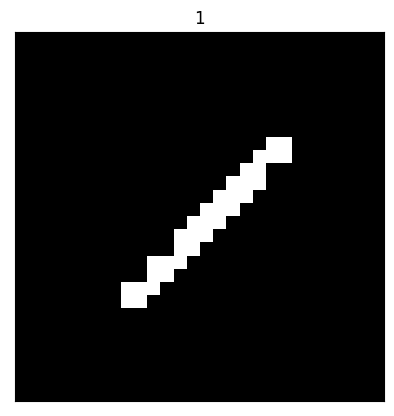

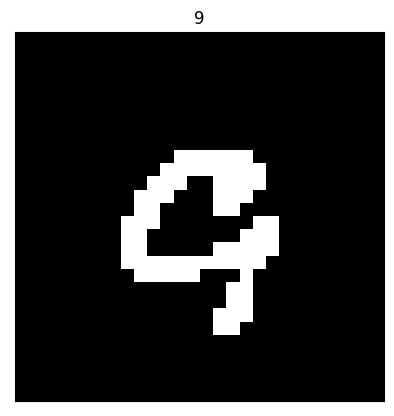

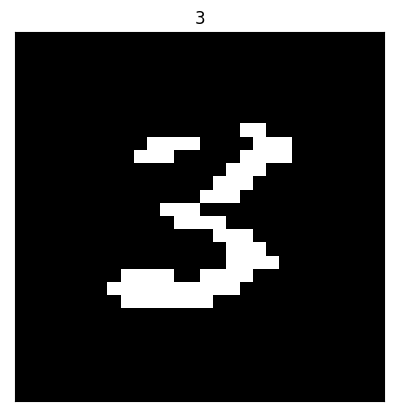

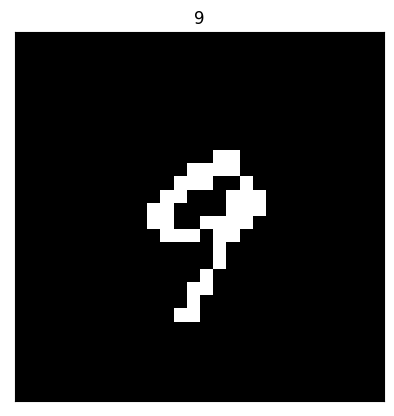

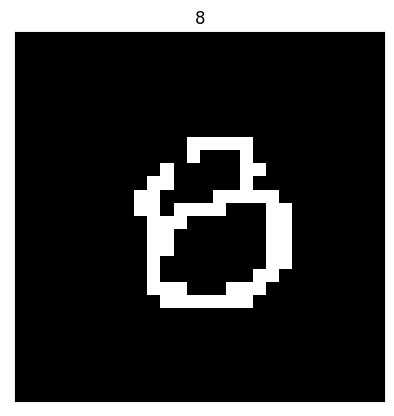

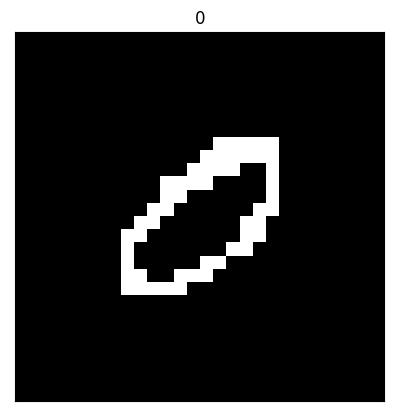

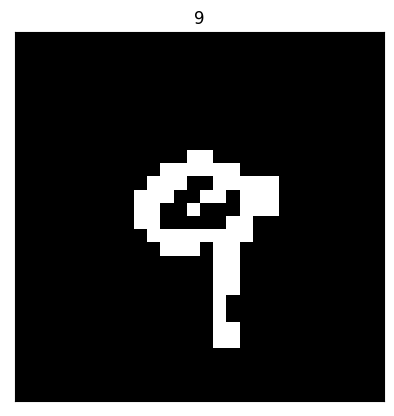

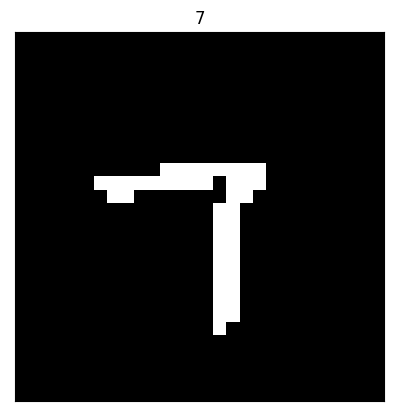

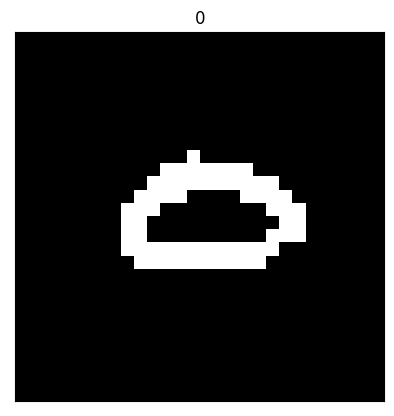

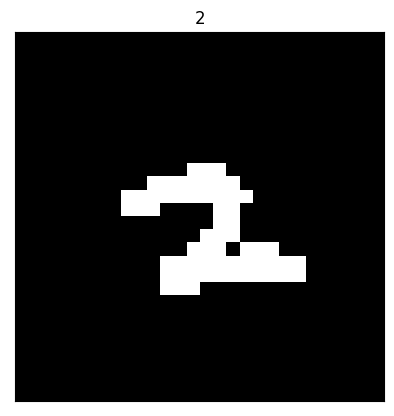

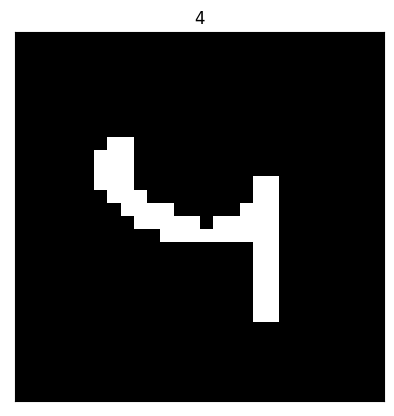

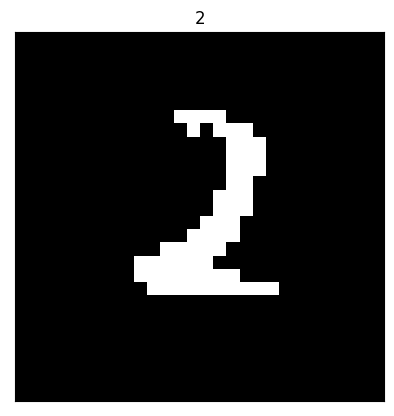

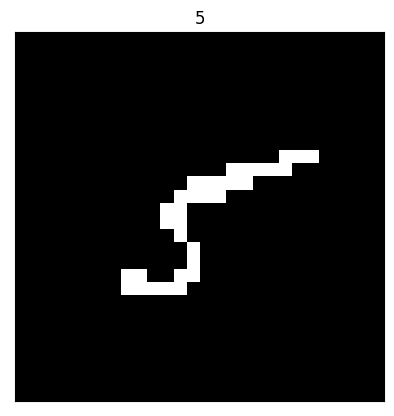

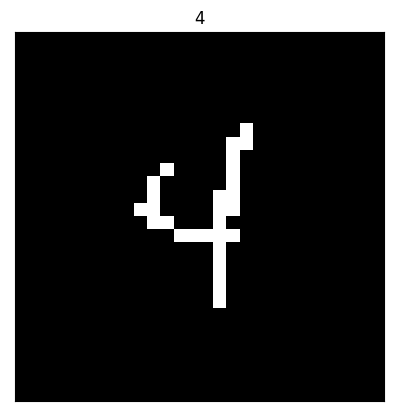

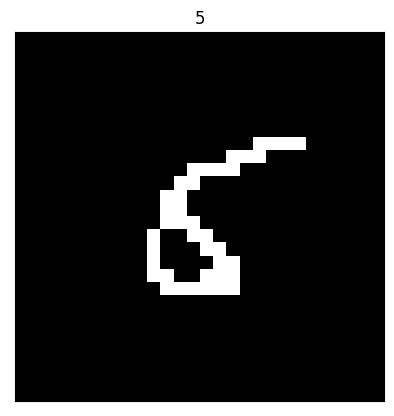

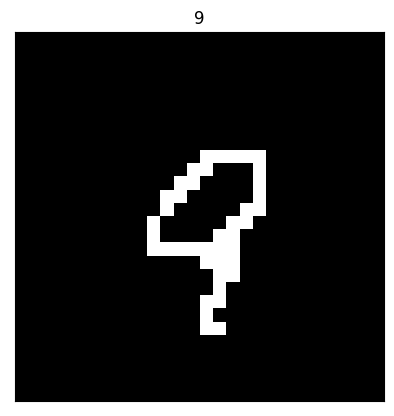

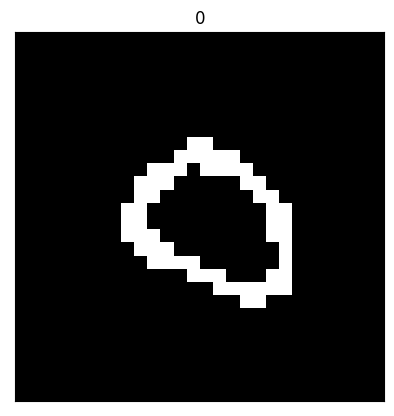

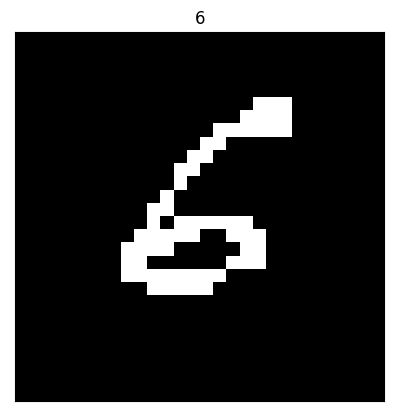

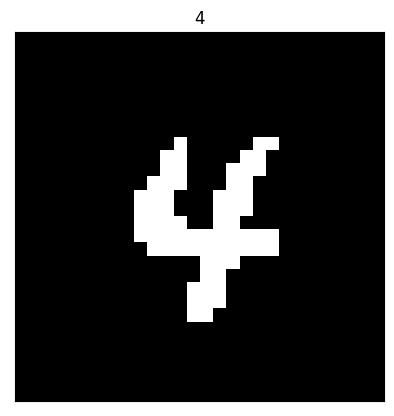

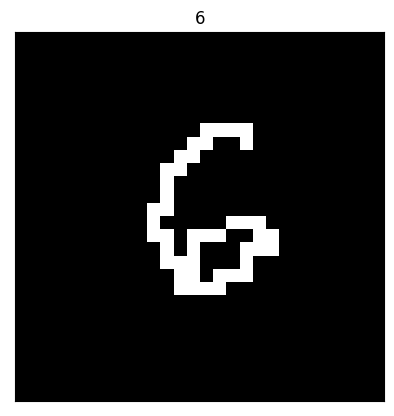

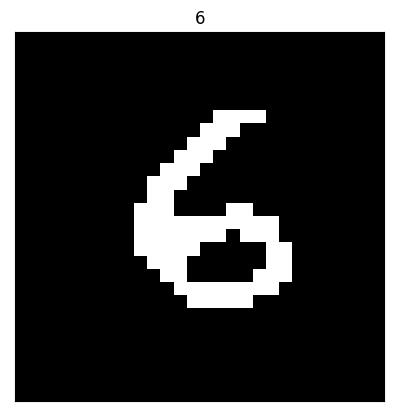

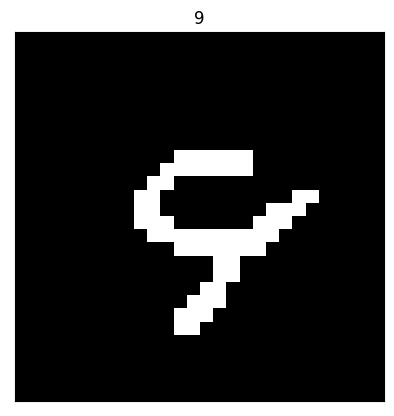

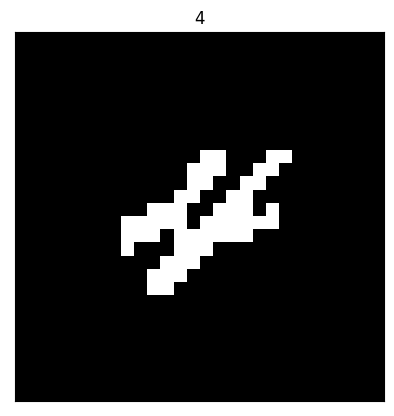

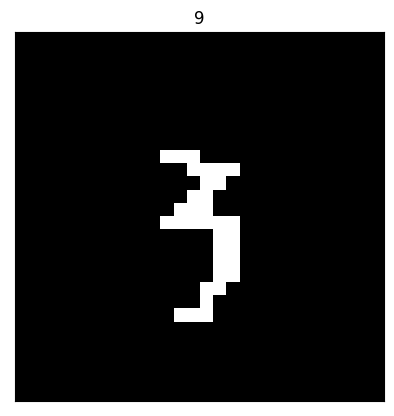

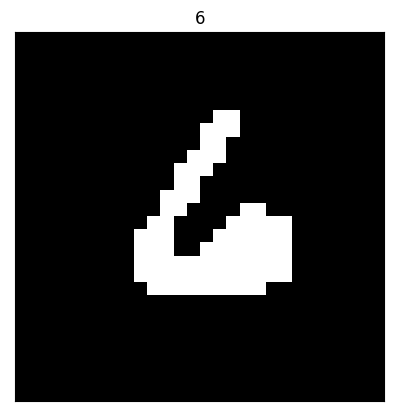

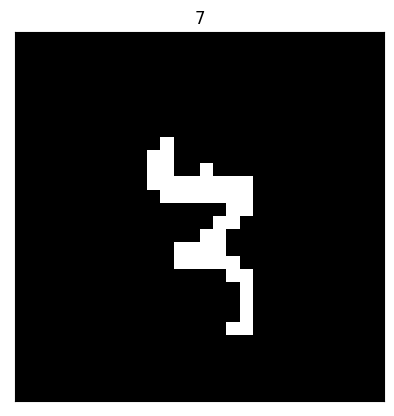

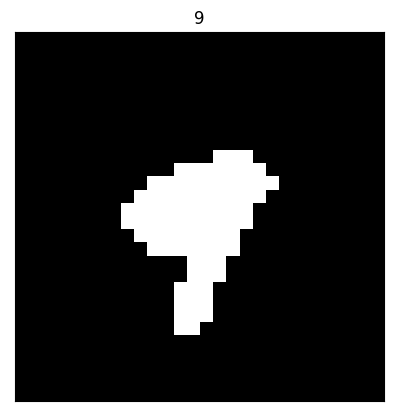

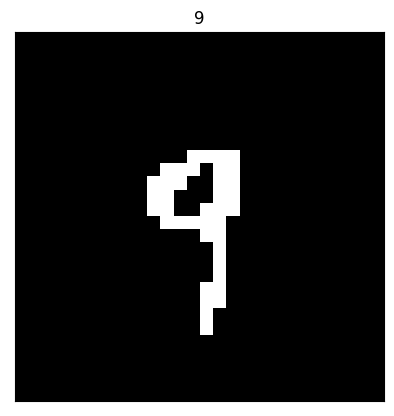

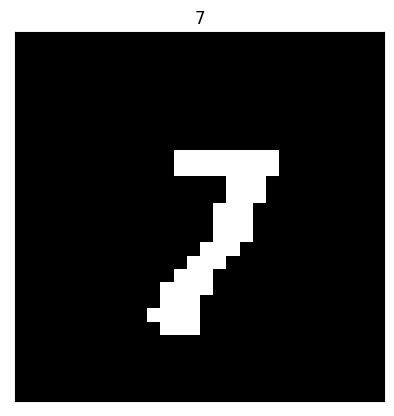

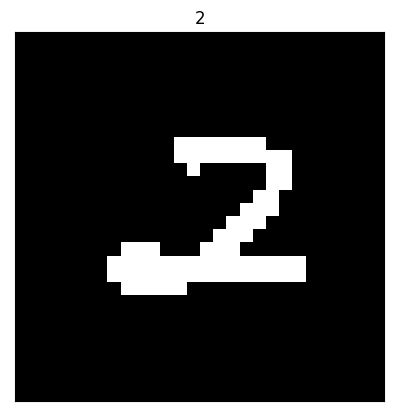

In [12]:
begin = np.random.randint(9970)
print(begin)
for i in range(begin, begin + 30):
    plt.figure()
    plt.imshow(x_test[i], cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.title(f'{np.argmax(predictions[i])}')
    plt.show()

    # transformed = transform(x_test[i], resize=True, offset=True, rotate=True) 
    # for img_t in transformed:
    #     plt.figure()
    #     plt.imshow(img_t, cmap='gray')
    #     plt.xticks([]), plt.yticks([])
    #     plt.title(f'{np.argmax(predictions[i])}')
    #     plt.show()

    # plt.figure()
    # plt.imshow(transform(x_train[i], resize=True, offset=True), cmap='gray')
    # plt.xticks([]), plt.yticks([])
    # # plt.title(f'{np.argmax(y_test[i])}')
    # plt.title(f'{y_train[i]}')
    # plt.show()